In [ ]:
 pip install openpyxl

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Mounted at /content/drive


In [ ]:
# Importing required modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
import random
import os

In [ ]:
# Defining functions
def train_test_split(data):
  """ Function to split the data into training and test set.Function takes
  dataset as its argument"""
  train_size = int(len(data)*0.5)# Using 50% for train and test split
  xtrain, xtest = data[:train_size], data[train_size:]
  return xtrain, xtest

def auto_model(xtrain):
  """ Function to identify optimal model using auto_arima. Function takes the
  training data as its argument"""
  # Passing NO2 Emission data as the dependent varaible and fertilizer consumption
  # and Temperature as independent (exogenous) variables.
  optimal_model = auto_arima(xtrain[:, 0],
                        exogenous= xtrain[:, 1:],
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
  return optimal_model

def sarimax_model (xtrain, order, seasonal_order):
  """Function to train the data using sarimax model and returns the trained model.
  Function takes the training data, order and seasonal order as arguments"""
  # Passing NO2 Emission data as the dependent varaible and fertilizer consumption
  # and Temperature as independent (exogenous) variables.
  sarimax_model = SARIMAX(xtrain[:, 0],
                        exog=xtrain[:, 1:],
                        order = order,
                        seasonal_order = seasonal_order)
  return sarimax_model

def create_sequence(df, step):
  """Function to create a sequence of the data where n number of steps becomes
  the input x and the n+1 th becomes the output y"""
  X = [] # Create an empty list  for X
  Y = [] # Create an empty list for Y
  # Creating aloop with a range equal to length of the dataframe
  for i in range(len(df)):
    # Setting end_ndex as the number of steps + 1
    end_index = i+step
    # Breaking the loop once the end index becomes greater that length of data
    if end_index > len(df)-1:
      break
    # creating an array from ith to end_index values as the input x_value
    x_value = df[i:end_index, :]
    # Storing the end_index value of column NO2 Emission to variable y_value
    y_value = df[end_index, 0]
    #Appending numpy array x_value to the input list X
    X.append(x_value)
    #Appending the y_value to the output list Y
    Y.append(y_value)
    #Returning both the list as numpy array
  return np.array(X), np.array(Y)

def sequence_split(df, step):
  """ Function to create sequences of the data and split the data into training
  and test dataset"""
  # Calling the create_sequence function to create sequences of the data based on
  # the number of steps passed.
  x, y = create_sequence(df, step)
  # Setting the train size as 50% of the length of data
  train_size = int(len(x)*0.5)
  #Splitting the data into train and test data
  x_train, x_test = x[:train_size], x[train_size: ]
  y_train, y_test = y[:train_size], y[train_size: ]
  return x_train, y_train, x_test, y_test

def reinitialize(model):
  """Function to reinitialize the weights and biases of the layers in neural
  network"""
  for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LSTM):
            for weight in layer.weights:
                if 'kernel' in weight.name:
                    weight.assign(tf.keras.initializers.GlorotUniform()(weight.shape))
                elif 'recurrent_kernel' in weight.name:
                    weight.assign(tf.keras.initializers.Orthogonal()(weight.shape))
                elif 'bias' in weight.name:
                    weight.assign(tf.keras.initializers.Zeros()(weight.shape))
        elif isinstance(layer, tf.keras.layers.Dense):
            layer.kernel.assign(tf.keras.initializers.GlorotUniform()(layer.kernel.shape))
            if layer.bias is not None:
                layer.bias.assign(tf.keras.initializers.Zeros()(layer.bias.shape))

def set_seeds(seed=42):
  """Function to set random seeds to reproduce the output evertime the
  code has been run"""
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  random.seed(seed)

def meta_model(forecast1, forecast2, test_data):
  """Function achieves stacking EML approach using LinearRegression as the
  meta model and train on the outputs of the base model passed as the arguments"""
  # Stacking the forecast of the base models
  stacked_forecast = np.column_stack((forecast1, forecast2))
  model = LinearRegression()
  # Fitting the model using the stacked values and the actual test data
  model.fit(stacked_forecast, test_data)
  # Returns the trained model and the stacked values
  return model, stacked_forecast

def eml_open_loop (xtrain, xtest, x_train, x_test, y_train, y_test, model):
  """Function to create an openloop architecture for the EML approach by using
  two methods, SARIMAX and LSTM. SARIMAX is defined as the internal_method and
  LSTM is passsed as as external argument to the function along with the train
  and test dataset"""
  openloop_forecast1 = [] # Create an empty list to store SARIMAX forecast
  openloop_forecast2 = [] # Create an empty list to store LSTM forecast
  # Calling optimal model function to identify the optimal parameters for SARIMAX
  optimal_model = auto_model(xtrain)
  order = optimal_model.order
  seasonal_order = optimal_model.seasonal_order
  # Creating a train and test loop for SARIMAX with a range of the length
  # of test data where the model will predict ith data of the test dataset and then
  # add the ith actual test data to the traning dataset and then train again
  # to predict the next ith test value and the loop continues until all test data
  # has been predicted.
  for i in range(1,len(xtest)+1):
    internal_model = sarimax_model(xtrain, order, seasonal_order)
    internal_model_fit = internal_model.fit()
    prediction = internal_model_fit.forecast(steps=1,
                              exog=xtest[i-1, 1:])
    openloop_forecast1.append(prediction)
    xtrain = np.concatenate((xtrain, xtest[i-1, :].reshape(1,3)), axis=0)
  # Creating a train and test loop for LSTM with a range of the length
  # of test data where the model will predict ith data of the test dataset and then
  # add the ith actual test data to the traning dataset and then train again
  # to predict the next ith test value and the loop continues until all test data
  # has been predicted.
  for i in range (1, len(x_test)+1):
    set_seeds()
    model.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
    model.optimizer.learning_rate = 0.01
    reinitialize(model)
    model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=150)
    prediction = model.predict(x_test[i-1, : ].reshape(1, 5, 3))
    openloop_forecast2.append(prediction)
    x_train = np.concatenate((x_train, x_test[i-1, : ].reshape(1, 5, 3)), axis=0)
    y_train = np.concatenate((y_train, y_test[i-1].reshape(1)), axis=0)
  # Creating a list  from a list of array of forecasted values and converts it
  # into an array of forecasted values
  openloop_forecast1 = [item for array in openloop_forecast1 for item in array]
  openloop_forecast1 = np.array(openloop_forecast1).reshape(len(openloop_forecast1), -1)
  openloop_forecast2 = [item for array in openloop_forecast2 for item in array]
  openloop_forecast2 = np.array(openloop_forecast2).reshape(len(openloop_forecast2), -1)
  # Calling the meta_model function to apply the eml approach to forecasted values
  eml_model, stack_value = meta_model(openloop_forecast1[3:], openloop_forecast2, y_test)
  eml_forecast = eml_model.predict(stack_value).reshape(stack_value.shape[0], -1)
  # Return the EML forecast
  return eml_forecast

def eml_closed_loop (xtrain, xtest, x_train, x_test, y_train, y_test, model):
  """Function to create an closed loop architecture for the EML approach by using
  two methods, SARIMAX and LSTM. SARIMAX is defined as the internal_method and
  LSTM is passsed as as external argument to the function along with the train
  and test dataset"""
  closedloop_forecast1 = [] # Create an empty list to store SARIMAX forecast
  closedloop_forecast2 = [] # Create an empty list to store LSTM forecast
  # Calling optimal model function to identify the optimal parameters for SARIMAX
  optimal_model = auto_model(xtrain)
  order = optimal_model.order
  seasonal_order = optimal_model.seasonal_order
  # Creating a train and test loop for SARIMAX with a range of the length
  # of test data where the model will predict ith data of the test dataset and then
  # add the predicted value to the traning dataset and then train again
  # to predict the next ith test value and the loop continues until all test data
  # has been predicted.
  for i in range(1,len(xtest)+1):
    internal_model = sarimax_model(xtrain, order, seasonal_order)
    internal_model_fit = internal_model.fit()
    prediction = internal_model_fit.forecast(steps=1,
                              exog=xtest[i-1, 1:])
    closedloop_forecast1.append(prediction)
    # Concatenating the predicted value with the actual values of independent variables.
    prediction = np.concatenate((prediction.reshape(1,1), xtest[i-1, 1:].reshape(1,2)), axis=1)
    # Adding the predicted value to the train dataset
    xtrain = np.concatenate((xtrain, prediction), axis=0)
  # Creating a train and test loop for LSTM with a range of the length
  # of test data where the model will predict ith data of the test dataset and then
  # add the predicted value to the traning dataset and then train again
  # to predict the next ith test value and the loop continues until all test data
  # has been predicted.
  for i in range (1, len(x_test)+1):
    set_seeds()
    model.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
    model.optimizer.learning_rate = 0.01
    reinitialize(model)
    model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=150)
    prediction = model.predict(x_test[i-1, : ].reshape(1, 5, 3))
    closedloop_forecast2.append(prediction)
    x_train = np.concatenate((x_train, x_test[i-1, : ].reshape(1, 5, 3)), axis=0)
    # Adding the predicted value to the train dataset
    y_train = np.concatenate((y_train, prediction.reshape(1)), axis=0)
  # Creating a list  from a list of array of forecasted values and converts it
  # into an array of forecasted values
  closedloop_forecast1 = [item for array in closedloop_forecast1 for item in array]
  closedloop_forecast1 = np.array(closedloop_forecast1).reshape(len(closedloop_forecast1), -1)
  closedloop_forecast2 = [item for array in closedloop_forecast2 for item in array]
  closedloop_forecast2 = np.array(closedloop_forecast2).reshape(len(closedloop_forecast2), -1)
  # Calling the meta_model function to apply the eml approach to forecasted values
  eml_model, stack_value = meta_model(closedloop_forecast1[3:], closedloop_forecast2, y_test)
  eml_forecast = eml_model.predict(stack_value).reshape(stack_value.shape[0], -1)
  # Return the EML forecast
  return eml_forecast

In [ ]:
#Import the excel file using pd.read_excel
cluster_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/clustered_forecast_data.xlsx').drop(columns=['Unnamed: 0'])

In [ ]:
print(cluster_df.head())

        Year      Country   Emission  Fertlizer_consumption  Temperature  \
0 1961-01-01  Afghanistan  2917273.5                   0.13    11.336061   
1 1962-01-01  Afghanistan  2891160.8                   0.13    11.144664   
2 1963-01-01  Afghanistan  2941533.2                   0.13    12.411098   
3 1964-01-01  Afghanistan  3004207.0                   0.13    10.428792   
4 1965-01-01  Afghanistan  3075739.0                   0.13    11.212704   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0  


In [ ]:
#Create a dataframe filtering out China data and dropping Cluster and Country columns
china_df = cluster_df[cluster_df['Country']=='China'].drop(columns=['Cluster', 'Country'])
#Set Year column as the index value
china_df.set_index('Year', inplace=True)

In [ ]:
#Create a dataframe filtering out US data and dropping Cluster and Country columns
us_df = cluster_df[cluster_df['Country']=='United States'].drop(columns=['Cluster', 'Country'])
#Set Year column as the index value
us_df.set_index('Year', inplace=True)

In [ ]:
#Check if the columns are stationary in China dataset using adfuller test
print("China :")
for col in china_df.columns:
    print(col)
    result = adfuller(china_df[col])
    print('p-value:', result[1])

China :
Emission
p-value: 0.43705876632596996
Fertlizer_consumption
p-value: 0.3591085281434664
Temperature
p-value: 0.9830421590144938


In [ ]:
#Check if the columns are stationary in US dataset using adfuller test
print("US :")
for col in us_df.columns:
    print(col)
    result = adfuller(us_df[col])
    print('p-value:', result[1])

US :
Emission
p-value: 0.0001300030999971149
Fertlizer_consumption
p-value: 0.027588015851473968
Temperature
p-value: 0.860455815128017


In [ ]:
#Create a statndard scaler for the china dataset
china_scaler = StandardScaler()
#Scale the values for all columns
scaled_china_df = china_scaler.fit_transform(china_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_china_df)

[[-1.639809   -1.72974923 -0.49242438]
 [-1.61894212 -1.69508566 -1.05668443]
 [-1.57558301 -1.6736401  -0.56592807]
 [-1.51535014 -1.63762775 -0.7787163 ]
 [-1.45578867 -1.56155672 -1.02151465]
 [-1.3780741  -1.45095699 -0.98733475]
 [-1.37787268 -1.54307847 -1.74241199]
 [-1.35103239 -1.51731683 -1.18818726]
 [-1.31729768 -1.45163138 -1.36795121]
 [-1.26264032 -1.35276601 -1.43526576]
 [-1.23038446 -1.35114748 -0.99923788]
 [-1.17725094 -1.28397838 -1.10531926]
 [-1.12197311 -1.20251224 -0.45582215]
 [-1.11911698 -1.28654106 -1.16680471]
 [-1.04687308 -1.11834854 -0.34749137]
 [-1.04495905 -1.1561143  -1.4770527 ]
 [-0.91353138 -0.84117483 -1.10064841]
 [-0.77011885 -0.54066728 -0.54920639]
 [-0.68268482 -0.3553453  -0.5782699 ]
 [-0.57475211 -0.15491701 -0.75116722]
 [-0.62913948 -0.2451502  -0.7027838 ]
 [-0.57869966 -0.22330001 -0.34416606]
 [-0.47516172 -0.12969488 -0.85620317]
 [-0.3792029  -0.06198626 -1.24103514]
 [-0.43765434 -0.30678932 -1.13895411]
 [-0.40950305 -0.35251286

In [ ]:
#Create a standard scaler for the US dataset
us_scaler = StandardScaler()
#Scale the values for all columns
scaled_us_df = us_scaler.fit_transform(us_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_us_df)

[[-3.3456788  -2.43534799 -1.1749111 ]
 [-2.81988293 -2.26043599 -0.68877155]
 [-2.17680172 -2.12885805 -0.48591404]
 [-1.62292749 -2.01146216 -1.2916514 ]
 [-0.962459   -1.82630756 -1.15676182]
 [-0.36953665 -1.58994    -1.32442176]
 [ 0.29827587 -1.33623881 -0.76590404]
 [ 0.71278535 -1.29763211 -1.26237015]
 [ 1.08545013 -1.27320746 -0.90159904]
 [ 0.69645169 -1.08174973 -0.99552802]
 [ 0.84735106 -1.02974886 -1.38375216]
 [ 1.07784921 -0.977748   -1.46599085]
 [ 1.59844289 -0.76895665 -0.5744866 ]
 [ 1.27000237 -0.78786605 -0.68436286]
 [ 1.34399846 -0.47507298 -1.34626189]
 [ 2.09103745 -0.24500854 -1.06227765]
 [ 1.84009271 -0.36398022 -0.06346978]
 [ 1.88873733 -0.3174946  -0.89086899]
 [ 1.76165074 -0.103188   -1.02621993]
 [ 1.09326221  0.06936032 -0.24707545]
 [ 0.90589161 -0.06852076  0.64381105]
 [ 0.06320791 -0.52234649 -1.20783472]
 [ 0.27225744 -0.31040357 -0.55596667]
 [ 0.4812825  -0.03385352 -0.80929966]
 [ 0.12416846 -0.20955341 -1.091806  ]
 [-0.19845609 -0.35925287

In [ ]:
#Call the train_test_split function to split the data for training and testing
xtrain,xtest = train_test_split(scaled_china_df)

In [ ]:
#Call the auto_model function to find the optimal parameters for SARIMAX model using auto_arima
optimal_model = auto_model(xtrain)
print(optimal_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.611, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.755, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.823, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.913, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.988, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.509 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  42.878
Date:                Mon, 26 Aug 2024   AIC                            -81.755
Time:                        13:55:59   BIC                            -79.021
Sample:                             0   HQIC                           -80.899
                    

In [ ]:
#copy the oprder and seasonal order form the optimal model
order = optimal_model.order
seasonal_order = optimal_model.seasonal_order
#Call sarimax model to train the model by passing the optimal orders and training data
sarimax_model1 = sarimax_model(xtrain, order, seasonal_order)
sarimax_model1_fit = sarimax_model1.fit()

In [ ]:
#Use the model to forecast the test data by passing the number of steps and the external variables
sarimax_model1_forecast = sarimax_model1_fit.forecast(steps=len(xtest),
                             exog=xtest[:, 1:])

In [ ]:
#Reshape the forecasted value into a 2D array of 1 column
sarimax_model1_forecast = sarimax_model1_forecast.reshape(sarimax_model1_forecast.shape[0], -1)

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
forecast_copy = np.repeat(sarimax_model1_forecast, 3, axis=-1)
unscaled_sarimax_model1_forecast = china_scaler.inverse_transform(forecast_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
sarimax_model1_mape = mean_absolute_percentage_error(china_df.iloc[len(xtrain):]['Emission'], unscaled_sarimax_model1_forecast)
print("SARIMAX MODEL 1")
print("MAPE : ",sarimax_model1_mape.round(3))

SARIMAX MODEL 1
MAPE :  0.154


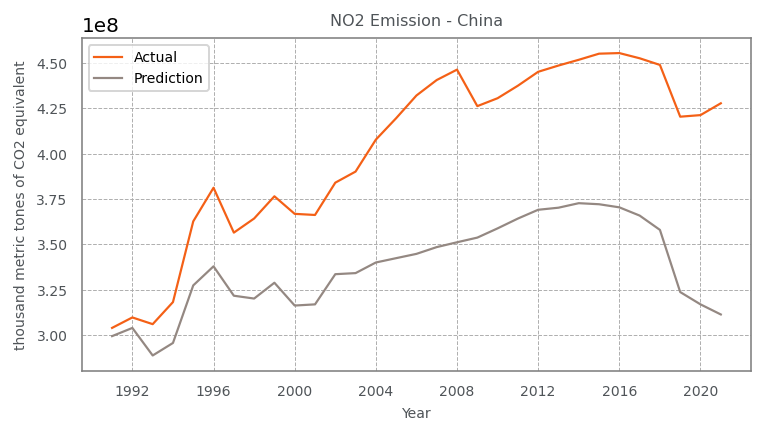

In [ ]:
#Create a line plot to compare the actual test value with the predicted value.

plt.figure(dpi=144, figsize=(6,3))
plt.plot(china_df.index[len(xtrain):], china_df.iloc[len(xtrain):]['Emission'], label="Actual",
            linewidth = 1.1, color = '#f46016')
plt.plot(china_df.index[len(xtrain):], unscaled_sarimax_model1_forecast, label='Prediction',
          linewidth = 1.1, color='#948882')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - China", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Call the train_test_split function to split the data for training and testing
xtrain,xtest = train_test_split(scaled_us_df)

In [ ]:
#Call the auto_model function to find the optimal parameters for SARIMAX model using auto_arima
optimal_model = auto_model(xtrain)
print(optimal_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=105.974, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42.918, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=78.558, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.301, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=38.739, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.339, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=40.105, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=40.567, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=42.233, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=39.765, Time=0.09 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 0.924 seconds
                               SARIMAX Results                                
Dep. Variable:                      y 

In [ ]:
#copy the oprder and seasonal order form the optimal model
order = optimal_model.order
seasonal_order = optimal_model.seasonal_order
#Call sarimax model to train the model by passing the optimal orders and training data
sarimax_model2 = sarimax_model(xtrain, order, seasonal_order)
sarimax_model2_fit = sarimax_model2.fit()

In [ ]:
#Use the model to forecast the test data by passing the number of steps and the external variables
sarimax_model2_forecast = sarimax_model2_fit.forecast(steps=len(xtest),
                             exog=xtest[:, 1:])

In [ ]:
#Reshape the forecasted value into a 2D array of 1 column
sarimax_model2_forecast = sarimax_model2_forecast.reshape(sarimax_model2_forecast.shape[0], -1)

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
forecast_copy = np.repeat(sarimax_model2_forecast, 3, axis=-1)
unscaled_sarimax_model2_forecast = us_scaler.inverse_transform(forecast_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
sarimax_model2_mape = mean_absolute_percentage_error(us_df.iloc[len(xtrain):]['Emission'], unscaled_sarimax_model2_forecast)
print("SARIMAX MODEL 1")
print("MAPE : ",sarimax_model2_mape.round(3))

SARIMAX MODEL 1
MAPE :  0.064


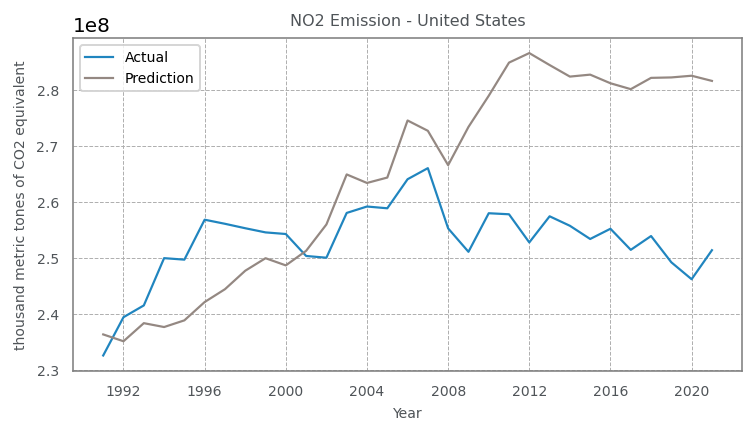

In [ ]:
#Create a line plot to compare the actual test value with the predicted value.
plt.figure(dpi=144, figsize=(6,3))
plt.plot(us_df.index[len(xtrain):], us_df.iloc[len(xtrain):]['Emission'], label="Actual",
            linewidth = 1.1, color = '#2085bf')
plt.plot(us_df.index[len(xtrain):], unscaled_sarimax_model2_forecast, label='Prediction',
          linewidth = 1.1, color='#948882')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - United States", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Call the create sequence function to create a sequence of input output values with a window of 5
x, y = create_sequence(scaled_china_df, 5)
print(x)
print(y)

[[[-1.639809   -1.72974923 -0.49242438]
  [-1.61894212 -1.69508566 -1.05668443]
  [-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]]

 [[-1.61894212 -1.69508566 -1.05668443]
  [-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]]

 [[-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]]

 [[-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]
  [-1.35103239 -1.51731683 -1.18818726]]

 [[-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]
  [-1.35103239 -1.51731683 -1.18818726]
  [-1.31729768 -1.45163138 -1.36

In [ ]:
# Split the data into a 50% ratio of train and test data
train_size = int(len(x)*0.5)
x_train, x_test = x[:train_size], x[train_size: ]
y_train, y_test = y[:train_size], y[train_size: ]

In [ ]:
# Develop the LSTM model 1
lstm_model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(5, 3), return_sequences=True),
    tf.keras.layers.LSTM(32, activation = 'relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])
print(lstm_model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Train the model with different optimizers and learning rate for 100 epochs
optimizers = ['SGD', 'adam', 'RMSprop']
learning_rate = np.linspace(0.0001, 0.01, 4)
hist = []
for opt in optimizers:
  for rate in learning_rate:
      set_seeds()
      lstm_model1.compile(optimizer=opt, loss='mse',  metrics=['mae'])
      lstm_model1.optimizer.learning_rate = rate
      #Call the reinitialize function to reinitialize the bias and weight for each layer
      reinitialize(lstm_model1)
      print("")
      print(f"optimizer: {opt}    learning rate: {rate}")
      print("")
      history = lstm_model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100)
      hist.append(history)


optimizer: SGD    learning rate: 0.0001

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.7616 - mae: 0.7322 - val_loss: 0.9982 - val_mae: 0.9553
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.7614 - mae: 0.7321 - val_loss: 0.9985 - val_mae: 0.9554
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7611 - mae: 0.7320 - val_loss: 0.9988 - val_mae: 0.9556
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7608 - mae: 0.7318 - val_loss: 0.9991 - val_mae: 0.9557
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.7606 - mae: 0.7317 - val_loss: 0.9993 - val_mae: 0.9559
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7603 - mae: 0.7315 - val_loss: 0.9996 - val_mae: 0.9560
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7600 - mae: 0.7314 - val_loss: 0.9999 - val_mae: 0.9562
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7598 - mae: 0.7313 - val_loss: 1.0002 - val_mae: 0.9563
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━

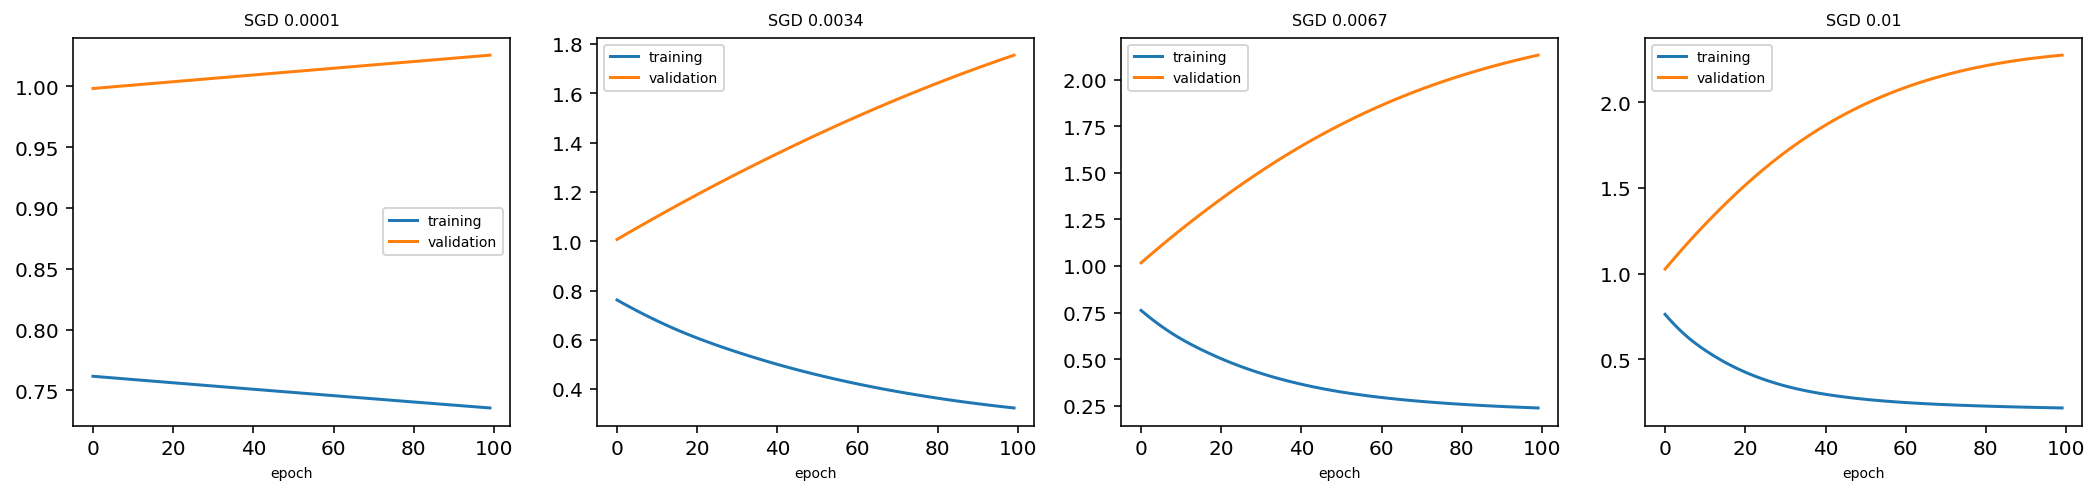

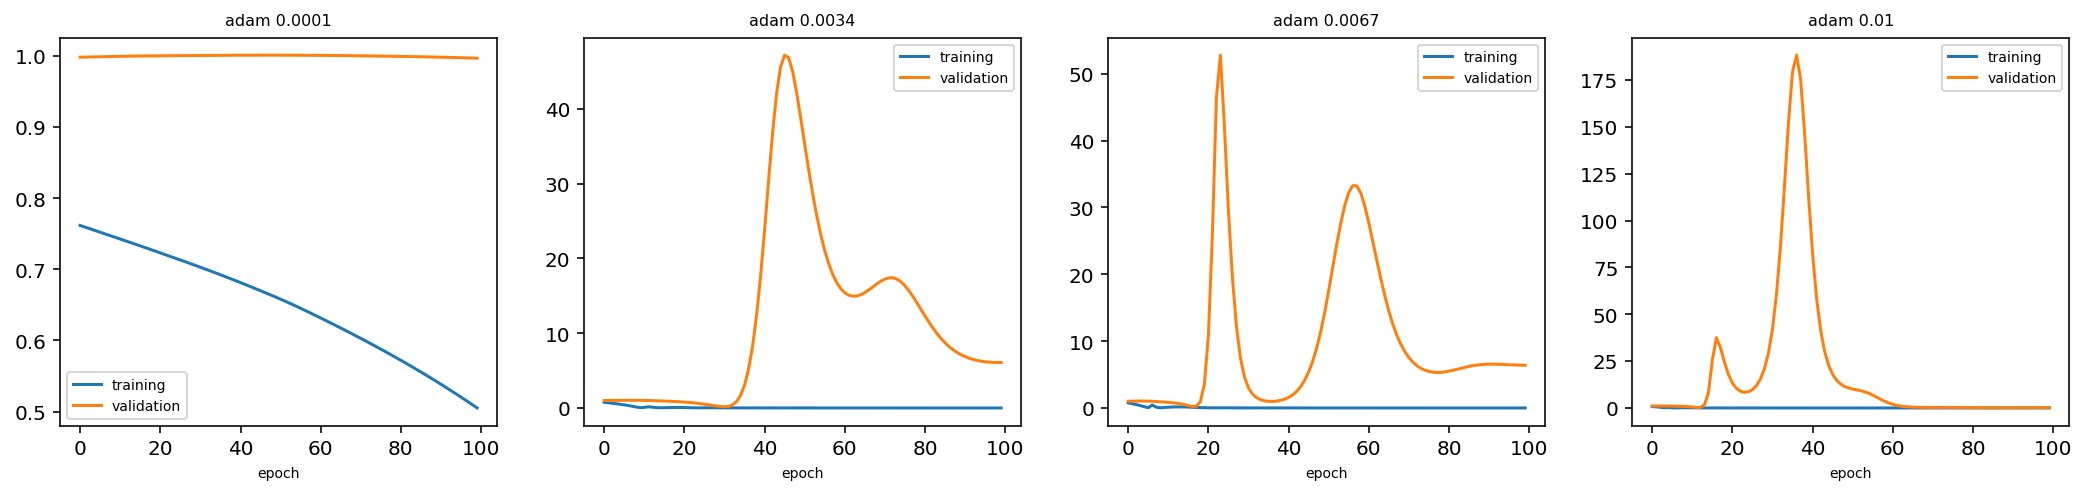

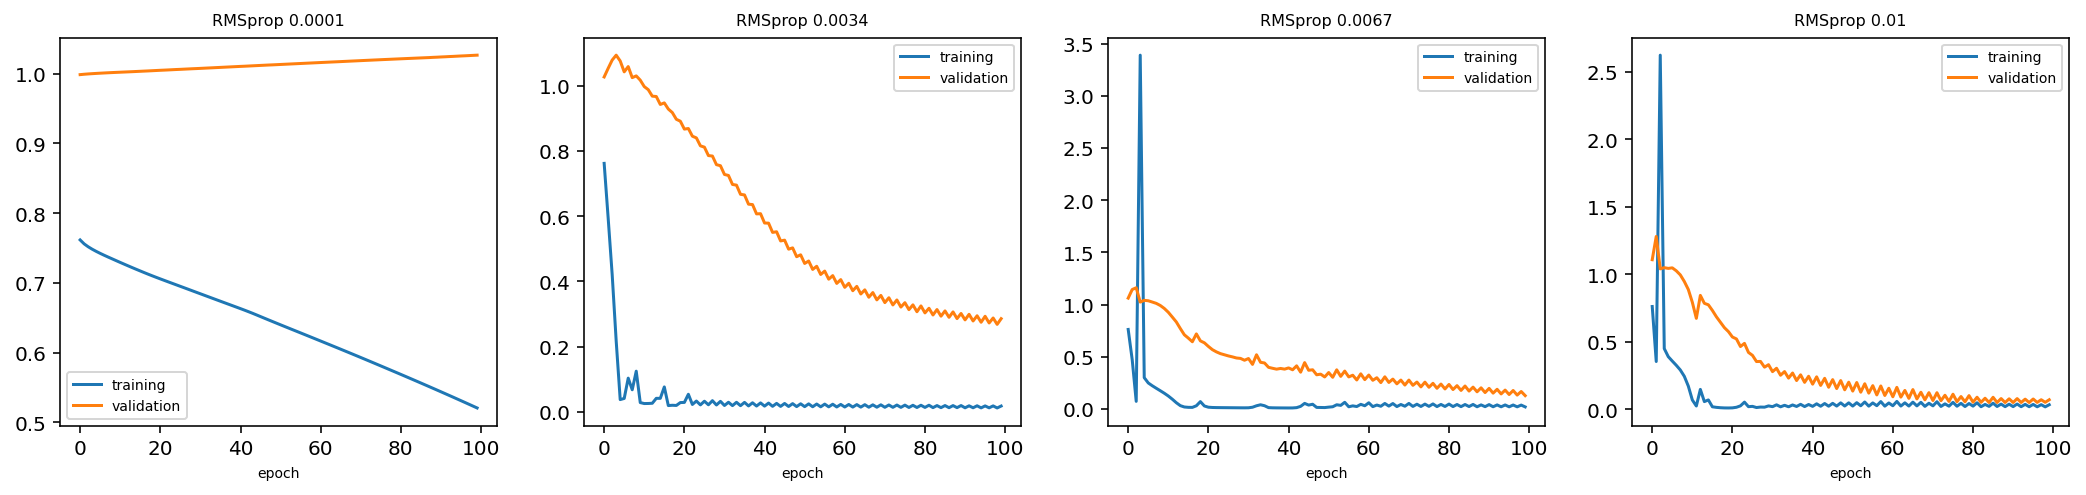

In [ ]:
#Plot the training and validation losses for each optimizer and learning rate
count = 0
for o in range(len(optimizers)):
  f, ax = plt.subplots(1, 4, figsize=(18,3.5), dpi=144)
  ax = ax.flatten()
  for r in range(len(learning_rate)):
      ax[r].plot(hist[count].history['loss'], label="training")
      ax[r].plot(hist[count].history['val_loss'], label="validation")
      ax[r].set_title(f"{optimizers[o]} {learning_rate[r].round(5)}", fontsize=8)
      ax[r].set_xlabel("epoch", fontsize=7)
      ax[r].legend(fontsize=7)
      count = count + 1

  plt.show()

In [ ]:
# Train the model with RMSprop and learning rate of 0.01 for 150 epochs
set_seeds()
hist = []
lstm_model1.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
lstm_model1.optimizer.learning_rate = 0.01
#Call the reinitialize function to reinitialize the weights and bias of each layer
reinitialize(lstm_model1)
history = lstm_model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=150)
hist.append(history)

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.7616 - mae: 0.7322 - val_loss: 1.1082 - val_mae: 1.0144
Epoch 2/150
1/1 [==============================] - 0s 55ms/step - loss: 0.3542 - mae: 0.5027 - val_loss: 1.2805 - val_mae: 1.1057
Epoch 3/150
1/1 [==============================] - 0s 49ms/step - loss: 2.6234 - mae: 1.4437 - val_loss: 1.0405 - val_mae: 0.9790
Epoch 4/150
1/1 [==============================] - 0s 69ms/step - loss: 0.4500 - mae: 0.5599 - val_loss: 1.0493 - val_mae: 0.9848
Epoch 5/150
1/1 [==============================] - 0s 52ms/step - loss: 0.3901 - mae: 0.5221 - val_loss: 1.0439 - val_mae: 0.9823
Epoch 6/150
1/1 [==============================] - 0s 50ms/step - loss: 0.3575 - mae: 0.5003 - val_loss: 1.0480 - val_mae: 0.9850
Epoch 7/150
1/1 [==============================] - 0s 44ms/step - loss: 0.3261 - mae: 0.4792 - val_loss: 1.0260 - val_mae: 0.9740
Epoch 8/150
1/1 [==============================] - 0s 53ms/step - loss: 0.2916 - mae: 0.4522

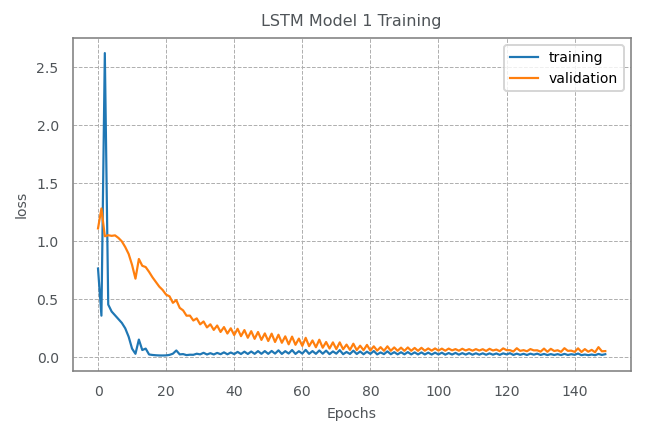

In [ ]:
#Plot the training and validation loss of the model

plt.figure(dpi=144, figsize=(5,3))
plt.plot(hist[0].history['loss'], label="training",
            linewidth = 1.1)
plt.plot(hist[0].history['val_loss'], label="validation",
          linewidth = 1.1)
plt.xlabel("Epochs", fontsize=7, color='#4f5458')
plt.ylabel("loss", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("LSTM Model 1 Training", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Use the model to predict the test value
lstm_model1_forecast = lstm_model1.predict(x_test)

1/1 [==============================] - 0s 243ms/step


In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(lstm_model1_forecast, 3, axis=-1)
unscaled_lstm_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
lstm_model1_mape = mean_absolute_percentage_error(china_df.iloc[5+train_size:, 0], unscaled_lstm_model1_forecast)
print("LSTM MODEL 1")
print("MAPE : ",lstm_model1_mape.round(3))

LSTM MODEL 1
MAPE :  0.056


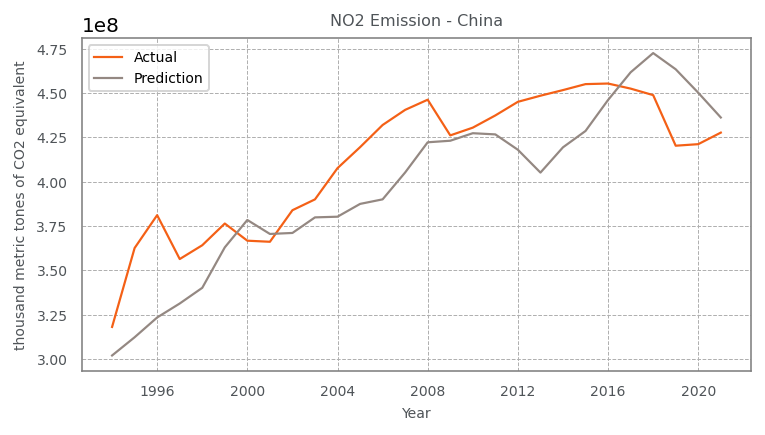

In [ ]:
#Create a line plot to compare the actual test value with the forecast value
plt.figure(dpi=144, figsize=(6,3))
plt.plot(china_df.index[5+train_size:], china_df.iloc[5+train_size:, 0], label="Actual",
            linewidth = 1.1, color = '#f46016')
plt.plot(china_df.index[5+train_size:],  unscaled_lstm_model1_forecast, label='Prediction',
          linewidth = 1.1, color='#948882')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - China", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Call the create sequence function to create a sequence of input output values with a window of 5
x, y = create_sequence(scaled_us_df, 5)

In [ ]:
# Split the data into a 50% ratio of train and test data
train_size = int(len(x)*0.5)
x_train, x_test = x[:train_size], x[train_size: ]
y_train, y_test = y[:train_size], y[train_size: ]

In [ ]:
# Develop the LSTM model 2
lstm_model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(5, 3), return_sequences=True),
    tf.keras.layers.LSTM(32, activation = 'relu', return_sequences=False),
    tf.keras.layers.Dense(1, kernel_regularizer = tf.keras.regularizers.l2(0.01))
])
print(lstm_model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# Train the model with different optimizers and learning rate for 100 epochs
optimizers = ['SGD', 'adam', 'RMSprop']
learning_rate = np.linspace(0.0001, 0.01, 4)
hist = []
for opt in optimizers:
  for rate in learning_rate:
      set_seeds()
      lstm_model2.compile(optimizer=opt, loss='mse',  metrics=['mae'])
      lstm_model2.optimizer.learning_rate = rate
      print("")
      print(f"optimizer: {opt}    learning rate: {rate}")
      print("")
      #Call the reinitialize function to reinitialize the bias and weight for each layer
      reinitialize(lstm_model2)
      history = lstm_model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100)
      hist.append(history)


optimizer: SGD    learning rate: 0.0001

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.1590 - mae: 0.9100 - val_loss: 0.0816 - val_mae: 0.2020
Epoch 2/100
1/1 [==============================] - 0s 47ms/step - loss: 1.1589 - mae: 0.9100 - val_loss: 0.0817 - val_mae: 0.2020
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 1.1588 - mae: 0.9099 - val_loss: 0.0817 - val_mae: 0.2021
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 1.1587 - mae: 0.9099 - val_loss: 0.0817 - val_mae: 0.2021
Epoch 5/100
1/1 [==============================] - 0s 46ms/step - loss: 1.1585 - mae: 0.9099 - val_loss: 0.0817 - val_mae: 0.2021
Epoch 6/100
1/1 [==============================] - 0s 44ms/step - loss: 1.1584 - mae: 0.9098 - val_loss: 0.0817 - val_mae: 0.2022
Epoch 7/100
1/1 [==============================] - 0s 45ms/step - loss: 1.1583 - mae: 0.9098 - val_loss: 0.0818 - val_mae: 0.2022
Epoch 8/100
1/1 [==============================] -

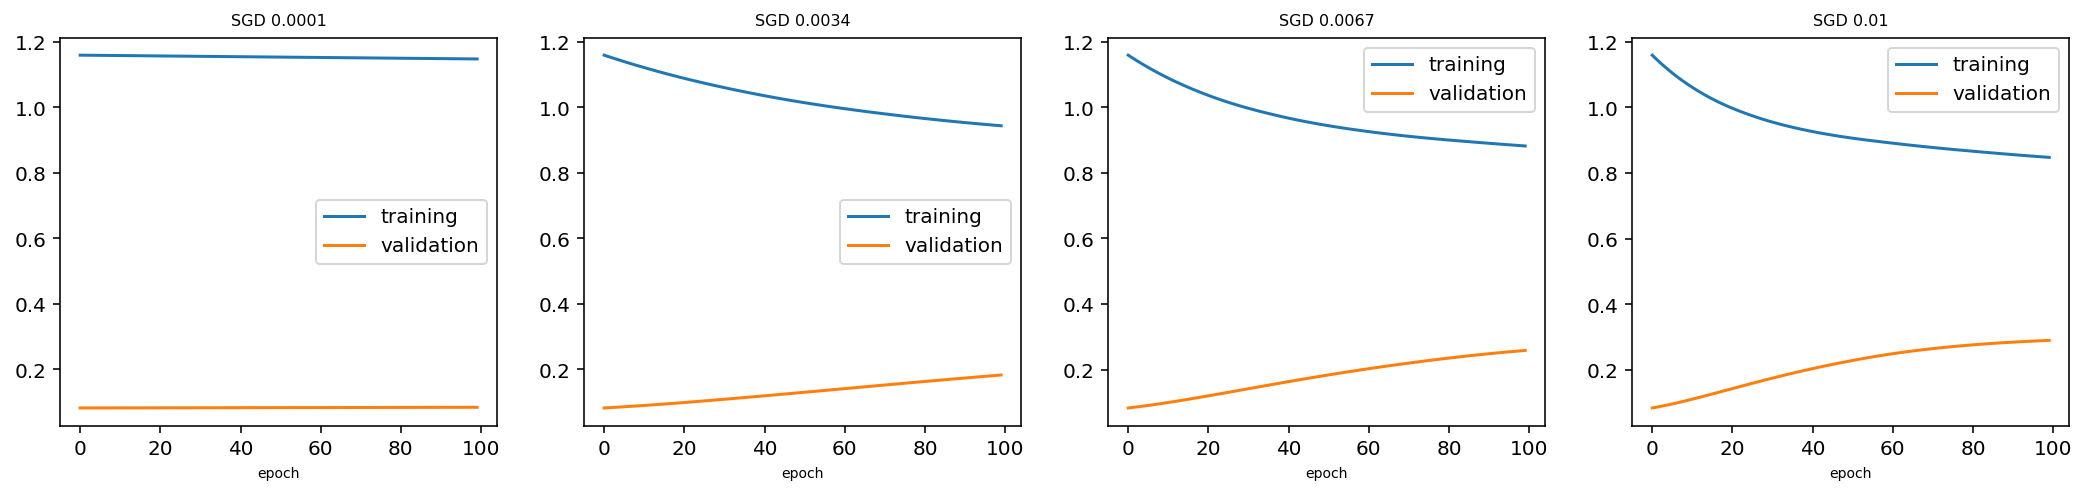

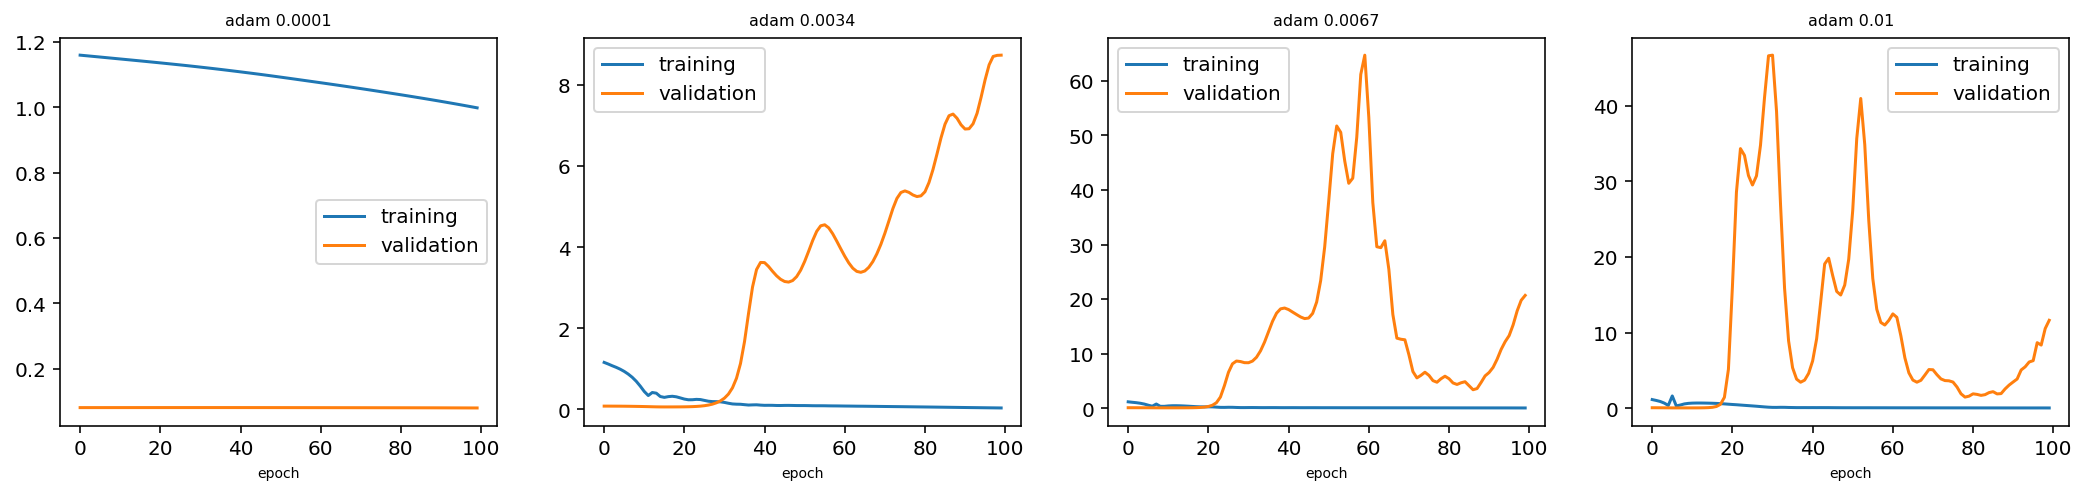

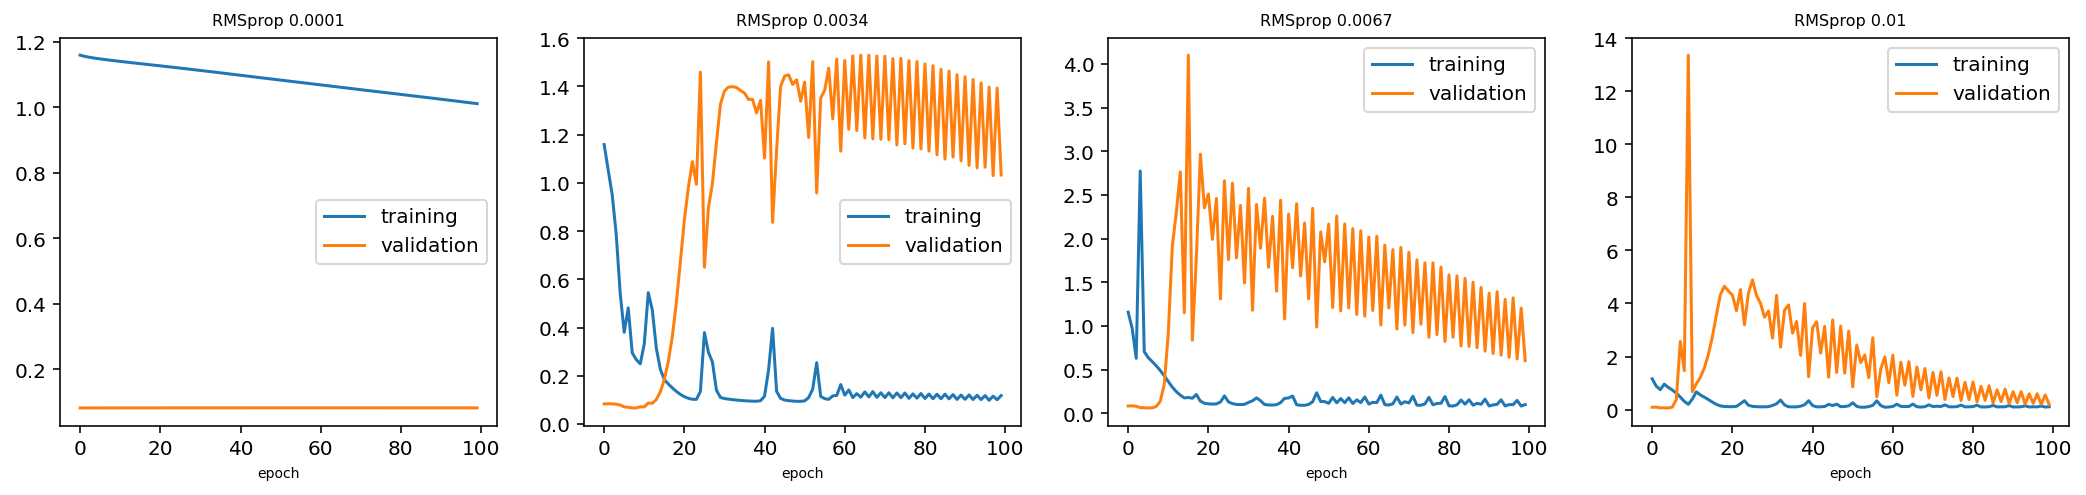

In [ ]:
#Plot the training and validation losses for each optimizer and learning rate
count = 0
for o in range(len(optimizers)):
  f, ax = plt.subplots(1, 4, figsize=(18,3.5), dpi=144)
  ax = ax.flatten()
  for r in range(len(learning_rate)):
      ax[r].plot(hist[count].history['loss'], label="training")
      ax[r].plot(hist[count].history['val_loss'], label="validation")
      ax[r].set_title(f"{optimizers[o]} {learning_rate[r].round(5)}", fontsize=8)
      ax[r].set_xlabel("epoch", fontsize=7)
      ax[r].legend()
      count = count + 1

  plt.show()

In [ ]:
# Train the model with RMSprop and learning rate of 0.01 for 200 epochs
set_seeds()
hist = []
lstm_model2.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
lstm_model2.optimizer.learning_rate = 0.01
reinitialize(lstm_model2)
history = lstm_model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=200)
hist.append(history)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 1.1590 - mae: 0.9100 - val_loss: 0.0882 - val_mae: 0.2197
Epoch 2/200
1/1 [==============================] - 0s 48ms/step - loss: 0.8825 - mae: 0.7920 - val_loss: 0.0912 - val_mae: 0.2273
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 0.7484 - mae: 0.7848 - val_loss: 0.0653 - val_mae: 0.1798
Epoch 4/200
1/1 [==============================] - 0s 51ms/step - loss: 0.9573 - mae: 0.8238 - val_loss: 0.0640 - val_mae: 0.1783
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 0.8356 - mae: 0.7715 - val_loss: 0.0606 - val_mae: 0.1669
Epoch 6/200
1/1 [==============================] - 0s 65ms/step - loss: 0.7378 - mae: 0.7203 - val_loss: 0.0926 - val_mae: 0.2162
Epoch 7/200
1/1 [==============================] - 0s 91ms/step - loss: 0.6201 - mae: 0.6533 - val_loss: 0.3756 - val_mae: 0.5277
Epoch 8/200
1/1 [==============================] - 0s 49ms/step - loss: 0.4712 - mae: 0.5556

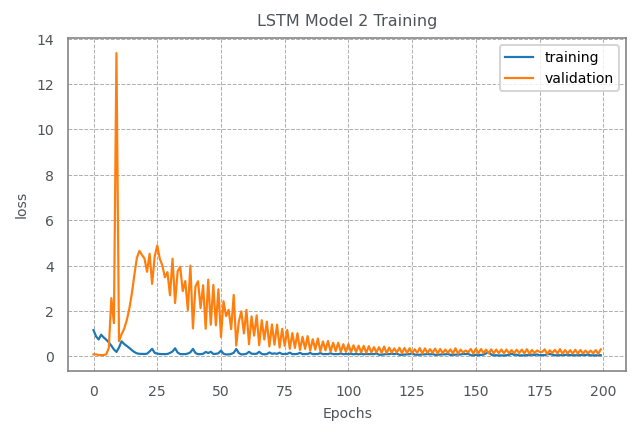

In [ ]:
#Plot the training and validation loss of the model
plt.figure(dpi=144, figsize=(5,3))
plt.plot(hist[0].history['loss'], label="training",
            linewidth = 1.1)
plt.plot(hist[0].history['val_loss'], label="validation",
          linewidth = 1.1)
plt.xlabel("Epochs", fontsize=7, color='#4f5458')
plt.ylabel("loss", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("LSTM Model 2 Training", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Use the model to predict the test value
lstm_model2_forecast = lstm_model2.predict(x_test)

1/1 [==============================] - 0s 260ms/step


In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(lstm_model2_forecast, 3, axis=-1)
unscaled_lstm_model2_forecast = us_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
lstm_model2_mape = mean_absolute_percentage_error(us_df.iloc[5+train_size:, 0], unscaled_lstm_model2_forecast)
print("LSTM MODEL 2")
print("MAPE : ",lstm_model2_mape.round(3))

LSTM MODEL 2
MAPE :  0.022


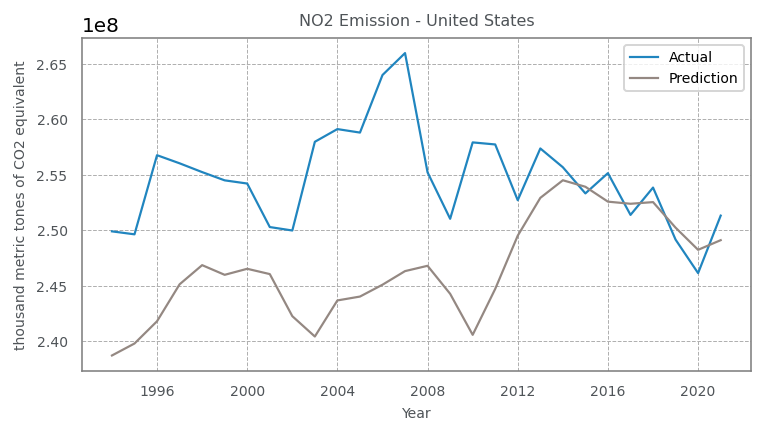

In [ ]:
#Create a line plot to compare the actual test value with the forecast value
plt.figure(dpi=144, figsize=(6,3))
plt.plot(us_df.index[5+train_size:], us_df.iloc[5+train_size:, 0],label="Actual",
            linewidth = 1.1, color = '#2085bf')
plt.plot(us_df.index[5+train_size:], unscaled_lstm_model2_forecast, label='Prediction',
          linewidth = 1.1, color='#948882')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - United States", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Calculating the average of the prediction made by both models for China dataset
#to implement the Average EML method
avg_eml_model1_forecast = (sarimax_model1_forecast[3: ] + lstm_model1_forecast)/2

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(avg_eml_model1_forecast, 3, axis=-1)
unscaled_avg_eml_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
avg_eml_model1_mape = mean_absolute_percentage_error(china_df.iloc[5+train_size:, 0], unscaled_avg_eml_model1_forecast)
print("AVERAGE EML MODEL 1")
print("MAPE : ",avg_eml_model1_mape.round(3))

AVERAGE EML MODEL 1
MAPE :  0.101


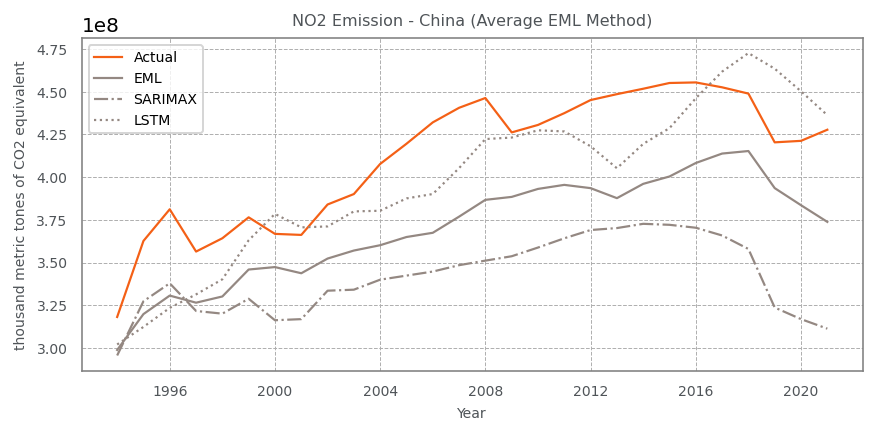

In [ ]:
#Create a line plot to compare the actual test value, forecasted value using SARIMAX and LSTM
#and the final forecast using Average EML method for the China dataset
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[5+train_size:], china_df.iloc[5+train_size:, 0],label="Actual",
            linewidth = 1.1, color = '#f46016')
plt.plot(china_df.index[5+train_size:], unscaled_avg_eml_model1_forecast, label='EML',
          linewidth = 1.1,  color = '#948882')
plt.plot(china_df.index[5+train_size:], unscaled_sarimax_model1_forecast[3:], label='SARIMAX',
          linewidth = 1.1, color = '#948882', linestyle='-.')
plt.plot(china_df.index[5+train_size:], unscaled_lstm_model1_forecast, label='LSTM',
          linewidth = 1.1, color = '#948882', linestyle=':')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - China (Average EML Method)", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Calculating the average of the prediction made by both models for US dataset
#to implement the Average EML method
avg_eml_model2_forecast = (sarimax_model2_forecast[3:] + lstm_model2_forecast) / 2

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(avg_eml_model2_forecast, 3, axis=-1)
unscaled_avg_eml_model2_forecast = us_scaler.inverse_transform(prediction_copy)[:, 0]

NameError: name 'np' is not defined

In [ ]:
#Print out the MAPE value of the forecast
avg_eml_model2_mape = mean_absolute_percentage_error(us_df.iloc[5+train_size:, 0], unscaled_avg_eml_model2_forecast)
print("AVERAGE EML MODEL 2")
print("MAPE : ",avg_eml_model2_mape.round(3))

NameError: name 'mean_absolute_percentage_error' is not defined

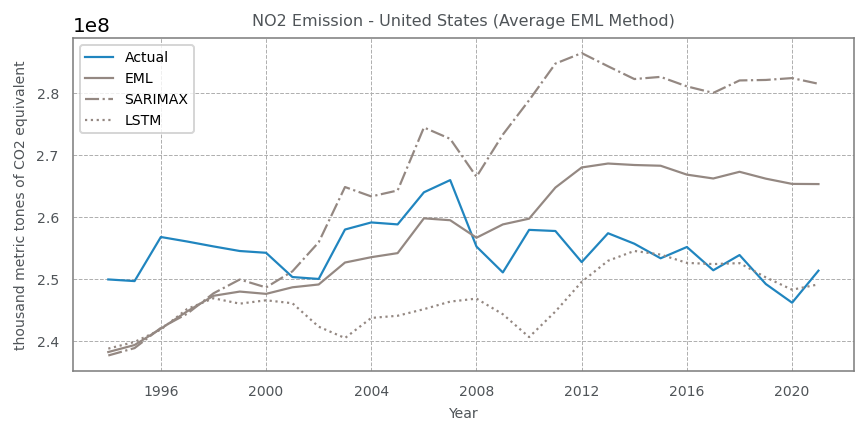

In [ ]:
#Create a line plot to compare the actual test value, forecasted value using SARIMAX and LSTM
#and the final forecast using Average EML method for the US dataset

plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[5+train_size:], us_df.iloc[5+train_size:, 0],label="Actual",
            linewidth = 1.1, color = '#2085bf')
plt.plot(us_df.index[5+train_size:], unscaled_avg_eml_model2_forecast, label='EML',
          linewidth = 1.1,  color = '#948882')
plt.plot(us_df.index[5+train_size:], unscaled_sarimax_model2_forecast[3:], label='SARIMAX',
          linewidth = 1.1, color = '#948882', linestyle='-.')
plt.plot(us_df.index[5+train_size:], unscaled_lstm_model2_forecast, label='LSTM',
          linewidth = 1.1, color = '#948882', linestyle=':')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - United States (Average EML Method)", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Call the meta_function to implement the stacking EML method by passing the
#forecasted values from both the base models and the actual test value of the China dataset
stack_eml_model, stacked_value = meta_model(sarimax_model1_forecast[3:], lstm_model1_forecast, scaled_china_df[5+train_size :, 0])

In [ ]:
#Use the stack eml model and the stacked forecast value of the two base models
#returned in the previous step to perform the prediction.
stack_eml_model1_forecast = stack_eml_model.predict(stacked_value).reshape(stacked_value.shape[0], -1)

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(stack_eml_model1_forecast, 3, axis=-1)
unscaled_stack_eml_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
stack_eml_model1_mape = mean_absolute_percentage_error(china_df.iloc[5+train_size:, 0], unscaled_stack_eml_model1_forecast)
print("STACK EML MODEL 1")
print("MAPE : ",stack_eml_model1_mape.round(3))

STACK EML MODEL 1
MAPE :  0.022


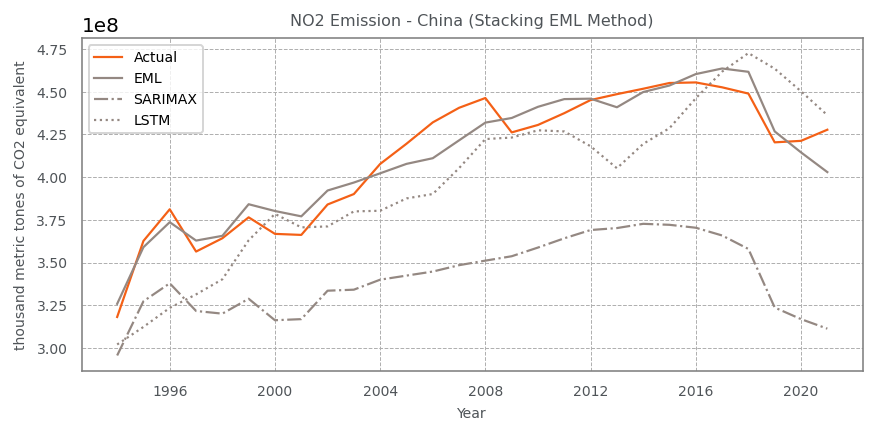

In [ ]:
#Create a line plot to compare the actual test value, forecasted value using SARIMAX and LSTM
#and the final forecast using Stacking EML method for the China dataset

plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[5+train_size:], china_df.iloc[5+train_size:, 0],label="Actual",
            linewidth = 1.1, color = '#f46016')
plt.plot(china_df.index[5+train_size:], unscaled_stack_eml_model1_forecast, label='EML',
          linewidth = 1.1,  color = '#948882')
plt.plot(china_df.index[5+train_size:], unscaled_sarimax_model1_forecast[3:], label='SARIMAX',
          linewidth = 1.1, color = '#948882', linestyle='-.')
plt.plot(china_df.index[5+train_size:], unscaled_lstm_model1_forecast, label='LSTM',
          linewidth = 1.1, color = '#948882', linestyle=':')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - China (Stacking EML Method)", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
#Call the meta_function to implement the stacking EML method by passing the
#forecasted values from both the base models and the actual test value of the US dataset
stack_eml_model, stack_value = meta_model(sarimax_model2_forecast[3:], lstm_model2_forecast, scaled_us_df[5+train_size :, 0])

NameError: name 'meta_model' is not defined

In [ ]:
#Use the stack eml model and the stacked forecast value of the two base models
#returned in the previous step to perform the prediction.
stack_eml_model2_forecast = stack_eml_model.predict(stack_value).reshape(stack_value.shape[0], -1)

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(stack_eml_model2_forecast, 3, axis=-1)
unscaled_stack_eml_model2_forecast = us_scaler.inverse_transform(prediction_copy)[:, 0]

NameError: name 'np' is not defined

In [ ]:
#Print out the MAPE value of the forecast
stack_eml_model2_mape = mean_absolute_percentage_error(us_df.iloc[5+train_size:, 0], unscaled_stack_eml_model2_forecast)
print("STACK EML MODEL 2")
print("MAPE : ",stack_eml_model2_mape.round(3))

STACK EML MODEL 2
MAPE :  0.013


In [ ]:
#Create a line plot to compare the actual test value, forecasted value using SARIMAX and LSTM
#and the final forecast using Stacking EML method for the US dataset
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[5+train_size:], us_df.iloc[5+train_size:, 0],label="Actual",
            linewidth = 1.1, color = '#2085bf')
plt.plot(us_df.index[5+train_size:], unscaled_stack_eml_model2_forecast, label='EML',
          linewidth = 1.1,  color = '#948882')
plt.plot(us_df.index[5+train_size:], unscaled_sarimax_model2_forecast[3:], label='SARIMAX',
          linewidth = 1.1, color = '#948882', linestyle='-.')
plt.plot(us_df.index[5+train_size:], unscaled_lstm_model2_forecast, label='LSTM',
          linewidth = 1.1, color = '#948882', linestyle=':')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - United States (Stacking EML Method)", fontsize=8, color='#4f5458')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Create a normal train test split and a sequence split of the China dataset
xtrain,xtest = train_test_split(scaled_china_df)
x_train, y_train, x_test, y_test = sequence_split(scaled_china_df, 5)

In [ ]:
#Call the eml_open_loop function to perform the EML method in open loop architcture
openloop_eml_model1_forecast = eml_open_loop(xtrain, xtest, x_train, x_test, y_train, y_test, lstm_model1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.611, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.755, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.823, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.913, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.988, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.900 seconds
Epoch 1/150
1/1 [==============================] - 5s 5s/step - loss: 0.7616 - mae: 0.7322 - val_loss: 1.1082 - val_mae: 1.0144
Epoch 2/150
1/1 [==============================] - 0s 48ms/step - loss: 0.3542 - mae: 0.5027 - val_loss: 1.2805 - val_mae: 1.1057
Epoch 3/150
1/1 [==============================] - 0s 51ms/step - loss: 2.6234 - mae: 1.4437 - val_loss: 1.0405 - val_mae: 0.9790
Epoch 4/150
1/1 [==============================] - 0s 46ms/step - loss: 0.4500 - mae: 0.5599 - val_loss: 1

1/1 [==============================] - 0s 418ms/step
Epoch 1/150
2/2 [==============================] - 3s 434ms/step - loss: 0.6666 - mae: 0.6888 - val_loss: 1.2693 - val_mae: 1.1013
Epoch 2/150
2/2 [==============================] - 0s 45ms/step - loss: 5.0431 - mae: 1.8493 - val_loss: 0.9661 - val_mae: 0.9425
Epoch 3/150
2/2 [==============================] - 0s 47ms/step - loss: 0.4355 - mae: 0.5586 - val_loss: 0.6922 - val_mae: 0.7941
Epoch 4/150
2/2 [==============================] - 0s 47ms/step - loss: 0.3917 - mae: 0.5186 - val_loss: 0.6619 - val_mae: 0.7803
Epoch 5/150
2/2 [==============================] - 0s 45ms/step - loss: 0.3248 - mae: 0.4763 - val_loss: 0.5651 - val_mae: 0.7234
Epoch 6/150
2/2 [==============================] - 0s 56ms/step - loss: 0.2608 - mae: 0.4290 - val_loss: 3.7066 - val_mae: 1.4808
Epoch 7/150
2/2 [==============================] - 0s 52ms/step - loss: 0.2286 - mae: 0.3854 - val_loss: 2.4042 - val_mae: 1.1592
Epoch 8/150
2/2 [===================

Streaming output truncated to the last 5000 lines.
Epoch 60/150
2/2 [==============================] - 0s 89ms/step - loss: 0.0215 - mae: 0.1174 - val_loss: 0.3295 - val_mae: 0.5461
Epoch 61/150
2/2 [==============================] - 0s 94ms/step - loss: 0.0468 - mae: 0.1726 - val_loss: 0.0134 - val_mae: 0.0974
Epoch 62/150
2/2 [==============================] - 0s 74ms/step - loss: 0.0111 - mae: 0.0864 - val_loss: 0.1350 - val_mae: 0.3350
Epoch 63/150
2/2 [==============================] - 0s 77ms/step - loss: 0.0413 - mae: 0.1718 - val_loss: 0.0153 - val_mae: 0.1012
Epoch 64/150
2/2 [==============================] - 0s 87ms/step - loss: 0.0147 - mae: 0.0986 - val_loss: 0.0356 - val_mae: 0.1602
Epoch 65/150
2/2 [==============================] - 0s 89ms/step - loss: 0.0676 - mae: 0.2245 - val_loss: 0.1049 - val_mae: 0.2955
Epoch 66/150
2/2 [==============================] - 0s 80ms/step - loss: 0.0763 - mae: 0.2419 - val_loss: 0.1153 - val_mae: 0.3122
Epoch 67/150
2/2 [==============

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(openloop_eml_model1_forecast, 3, axis=-1)
unscaled_openloop_eml_model1_forecast= china_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
openloop_eml_model1_mape = mean_absolute_percentage_error( china_df.iloc[33:, 0], unscaled_openloop_eml_model1_forecast)
print("EML MODEL 1 IN OPEN LOOP")
print("MAPE : ",openloop_eml_model1_mape.round(3))

EML MODEL 1 IN OPEN LOOP
MAPE :  0.012


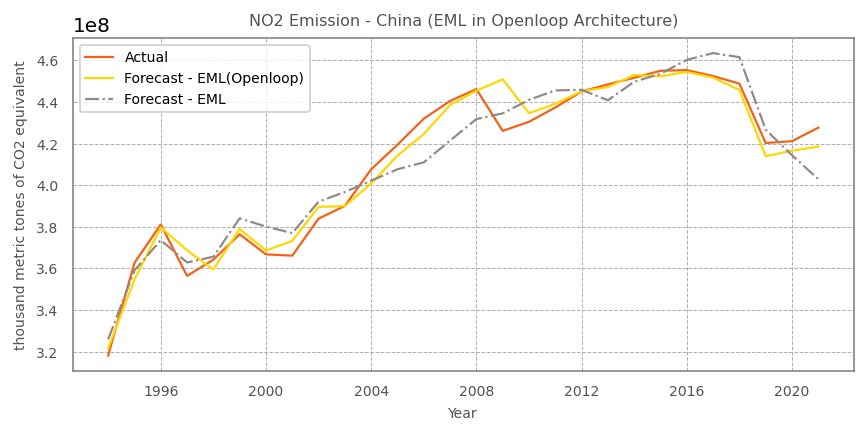

In [ ]:
#Create a line plot to compare the actual test value, normal EML forecast value
#and the final forecast using  EML method in open loop architecture for the China dataset

plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[33:], china_df.iloc[33:, 0],label="Actual",
            linewidth = 1.1, color = '#f46016')
plt.plot(china_df.index[33:], unscaled_openloop_eml_model1_forecast, label='Forecast - EML(Openloop)',
          linewidth = 1.1,  color = 'Gold')
plt.plot(china_df.index[33:], unscaled_stack_eml_model1_forecast, label='Forecast - EML',
          linewidth = 1.1, color = '#948882', linestyle='-.')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - China (EML in Openloop Architecture)", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
# Create a normal train test split and a sequence split of the US dataset
xtrain,xtest = train_test_split(scaled_us_df)
x_train, y_train, x_test, y_test = sequence_split(scaled_us_df, 5)

In [ ]:
#Call the eml_open_loop function to perform the EML method in open loop architcture
openloop_eml_model2_forecast = eml_open_loop(xtrain, xtest, x_train, x_test, y_train, y_test, lstm_model2)

NameError: name 'eml_open_loop' is not defined

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(openloop_eml_model2_forecast, 3, axis=-1)
unscaled_openloop_eml_model2_forecast= us_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
openloop_eml_model2_mape = mean_absolute_percentage_error(us_df.iloc[33:, 0], unscaled_openloop_eml_model2_forecast)
print("EML MODEL 2 IN OPEN LOOP")
print("MAPE : ",openloop_eml_model2_mape.round(3))

NameError: name 'mean_absolute_percentage_error' is not defined

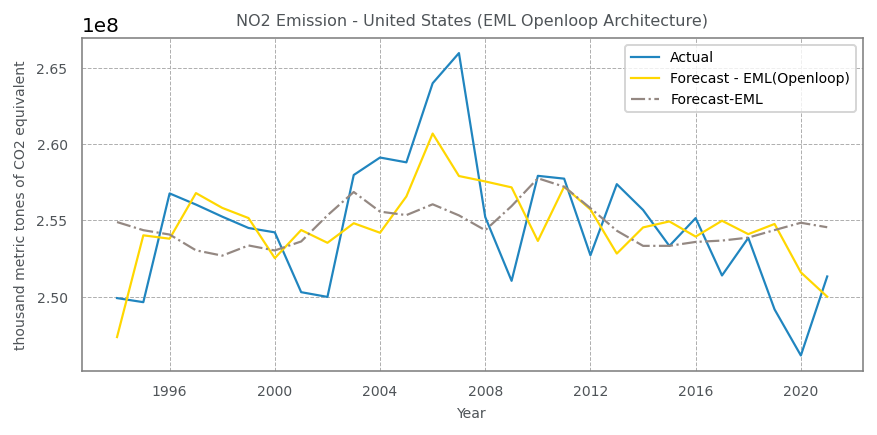

In [ ]:
#Create a line plot to compare the actual test value, normal EML forecast value
#and the final forecast using  EML method in open loop architecture for the US dataset
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[33:], us_df.iloc[33:, 0],label="Actual",
            linewidth = 1.1, color = '#2085bf')
plt.plot(us_df.index[33:], unscaled_openloop_eml_model2_forecast, label='Forecast - EML(Openloop)',
          linewidth = 1.1,  color = 'Gold')
plt.plot(us_df.index[33:], unscaled_stack_eml_model2_forecast, label='Forecast-EML',
          linewidth = 1.1,  color = '#948882', linestyle='-.')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - United States (EML Openloop Architecture)", fontsize=8, color='#4f5458')
plt.show()

In [ ]:
# Create a normal train test split and a sequence split of the China dataset
xtrain,xtest = train_test_split(scaled_china_df)
x_train, y_train, x_test, y_test = sequence_split(scaled_china_df, 5)

NameError: name 'train_test_split' is not defined

In [ ]:
#Call the eml_open_loop function to perform the EML method in closed loop architcture
closedloop_eml_model1_forecast = eml_closed_loop(xtrain, xtest, x_train, x_test, y_train, y_test, lstm_model1)

Streaming output truncated to the last 5000 lines.
Epoch 60/150
2/2 [==============================] - 0s 60ms/step - loss: 0.0253 - mae: 0.1254 - val_loss: 0.0258 - val_mae: 0.1291
Epoch 61/150
2/2 [==============================] - 0s 88ms/step - loss: 0.0091 - mae: 0.0786 - val_loss: 0.0975 - val_mae: 0.2832
Epoch 62/150
2/2 [==============================] - 0s 63ms/step - loss: 0.0121 - mae: 0.0845 - val_loss: 0.0269 - val_mae: 0.1308
Epoch 63/150
2/2 [==============================] - 0s 89ms/step - loss: 0.0231 - mae: 0.1192 - val_loss: 0.0460 - val_mae: 0.1805
Epoch 64/150
2/2 [==============================] - 0s 62ms/step - loss: 0.0464 - mae: 0.1698 - val_loss: 0.0517 - val_mae: 0.1813
Epoch 65/150
2/2 [==============================] - 0s 66ms/step - loss: 0.0355 - mae: 0.1550 - val_loss: 0.2330 - val_mae: 0.4608
Epoch 66/150
2/2 [==============================] - 0s 61ms/step - loss: 0.1735 - mae: 0.3495 - val_loss: 0.2346 - val_mae: 0.4627
Epoch 67/150
2/2 [==============

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(closedloop_eml_model1_forecast, 3, axis=-1)
unscaled_closedloop_eml_model1_forecast= china_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
closedloop_eml_model1_mape = mean_absolute_percentage_error(china_df.iloc[33:, 0], unscaled_closedloop_eml_model1_forecast)
print("EML MODEL 2 IN OPEN LOOP")
print("MAPE : ",closedloop_eml_model1_mape.round(3))

NameError: name 'mean_absolute_percentage_error' is not defined

In [ ]:
#Create a line plot to compare the actual test value, normal EML forecast value
#and the final forecast using  EML method in closed loop architecture for the China dataset
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[33:], china_df.iloc[33:, 0],label="Actual",
            linewidth = 1.1, color = '#f46016')
plt.plot(china_df.index[33:], unscaled_closedloop_eml_model1_forecast, label='Forecast - EML(Closedloop)',
          linewidth = 1.1,  color = 'LightSeaGreen')
plt.plot(china_df.index[33:], unscaled_stack_eml_model1_forecast, label='Forecast - EML',
          linewidth = 1.1, color = '#948882', linestyle='-.')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - China (EML in Closedloop Architecture)", fontsize=8, color='#4f5458')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Create a normal train test split and a sequence split of the China dataset
xtrain,xtest = train_test_split(scaled_us_df)
x_train, y_train, x_test, y_test = sequence_split(scaled_us_df, 5)

In [ ]:
#Call the eml_open_loop function to perform the EML method in closed loop architcture
closedloop_eml_model2_forecast = eml_closed_loop(xtrain, xtest, x_train, x_test, y_train, y_test, lstm_model2)

Streaming output truncated to the last 5000 lines.
Epoch 60/150
2/2 [==============================] - 0s 111ms/step - loss: 0.3467 - mae: 0.4344 - val_loss: 0.1145 - val_mae: 0.2272
Epoch 61/150
2/2 [==============================] - 0s 83ms/step - loss: 0.3367 - mae: 0.4024 - val_loss: 0.2583 - val_mae: 0.3544
Epoch 62/150
2/2 [==============================] - 0s 112ms/step - loss: 0.1440 - mae: 0.2410 - val_loss: 0.3084 - val_mae: 0.3890
Epoch 63/150
2/2 [==============================] - 0s 88ms/step - loss: 0.0741 - mae: 0.1720 - val_loss: 0.2431 - val_mae: 0.3489
Epoch 64/150
2/2 [==============================] - 0s 106ms/step - loss: 0.0638 - mae: 0.1691 - val_loss: 0.0665 - val_mae: 0.1779
Epoch 65/150
2/2 [==============================] - 0s 89ms/step - loss: 0.1026 - mae: 0.2472 - val_loss: 0.3259 - val_mae: 0.4204
Epoch 66/150
2/2 [==============================] - 0s 80ms/step - loss: 0.2277 - mae: 0.3471 - val_loss: 0.0922 - val_mae: 0.2034
Epoch 67/150
2/2 [===========

In [ ]:
#Duplicate the forecasted value column into 3 columns to unscale the forecasted value
prediction_copy = np.repeat(closedloop_eml_model2_forecast, 3, axis=-1)
unscaled_closedloop_eml_model2_forecast= us_scaler.inverse_transform(prediction_copy)[:, 0]

In [ ]:
#Print out the MAPE value of the forecast
closedloop_eml_model2_mape = mean_absolute_percentage_error(us_df.iloc[33:, 0], unscaled_closedloop_eml_model2_forecast)
print("EML MODEL 2 IN OPEN LOOP")
print("MAPE : ",closedloop_eml_model2_mape.round(3))

EML MODEL 2 IN OPEN LOOP
MAPE :  0.012


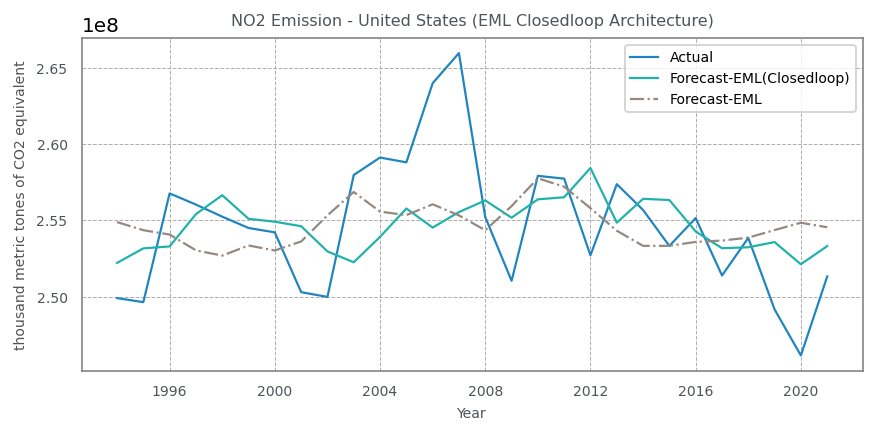

In [ ]:
#Create a line plot to compare the actual test value, normal EML forecast value
#and the final forecast using  EML method in closed loop architecture for the US dataset
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[33:], us_df.iloc[33:, 0],label="Actual",
            linewidth = 1.1, color = '#2085bf')
plt.plot(us_df.index[33:], unscaled_closedloop_eml_model2_forecast, label='Forecast-EML(Closedloop)',
          linewidth = 1.1,  color = 'LightSeaGreen')
plt.plot(us_df.index[33:], unscaled_stack_eml_model2_forecast, label='Forecast-EML',
          linewidth = 1.1,  color = '#948882', linestyle='-.')
plt.xlabel("Year", fontsize=7, color='#4f5458')
plt.ylabel("thousand metric tones of CO2 equivalent", fontsize=7, color='#4f5458')
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7, color='#4f5458')
plt.yticks(fontsize=7, color='#4f5458')
ax = plt.gca()
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.title("NO2 Emission - United States (EML Closedloop Architecture)", fontsize=8, color='#4f5458')
plt.show()